In [1]:
import pandas as pd
print("Pandas imported.")

Pandas imported.


In [2]:
df_tweets = pd.read_csv('Tweets.csv')
print("Tweets.csv loaded into df_tweets.")

Tweets.csv loaded into df_tweets.


In [3]:
import re

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

print("Function 'remove_urls' defined.")

Function 'remove_urls' defined.


In [4]:
def remove_mentions(text):
    mention_pattern = re.compile(r'@\w+')
    return mention_pattern.sub(r'', text)

print("Function 'remove_mentions' defined.")

Function 'remove_mentions' defined.


In [5]:
def remove_emojis(text):
    emoji_pattern = re.compile(r'['
                               u'\U0001F600-\U0001F64F'  # emoticons
                               u'\U0001F300-\U0001F5FF'  # symbols & pictographs
                               u'\U0001F680-\U0001F6FF'  # transport & map symbols
                               u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
                               u'\U00002702-\U000027B0'
                               u'\U000024C2-\U0001F251'
                               u']+', flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

print("Function 'remove_emojis' defined.")

Function 'remove_emojis' defined.


In [6]:
df_tweets['cleaned_text'] = df_tweets['text'].apply(remove_urls)
df_tweets['cleaned_text'] = df_tweets['cleaned_text'].apply(remove_mentions)
df_tweets['cleaned_text'] = df_tweets['cleaned_text'].apply(remove_emojis)

print("Cleaned text applied to 'cleaned_text' column.")
print(df_tweets[['text', 'cleaned_text']].head())

Cleaned text applied to 'cleaned_text' column.
                                                text  \
0                @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials t...   
2  @VirginAmerica I didn't today... Must mean I n...   
3  @VirginAmerica it's really aggressive to blast...   
4  @VirginAmerica and it's a really big bad thing...   

                                        cleaned_text  
0                                        What  said.  
1   plus you've added commercials to the experien...  
2   I didn't today... Must mean I need to take an...  
3   it's really aggressive to blast obnoxious "en...  
4           and it's a really big bad thing about it  


In [7]:
import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download en_core_web_sm

print("spaCy installed and 'en_core_web_sm' model downloaded.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 98.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
spaCy installed and 'en_core_web_sm' model downloaded.


In [8]:
import spacy

# Load the 'en_core_web_sm' language model
nlp = spacy.load('en_core_web_sm')

# Apply the loaded spaCy model to the 'cleaned_text' column
df_tweets['spacy_doc'] = df_tweets['cleaned_text'].apply(nlp)

# Extract lemmas and POS tags, excluding punctuation and whitespace
def extract_lemmas_pos(doc):
    lemmas = [token.lemma_ for token in doc if not token.is_punct and not token.is_space]
    pos_tags = [token.pos_ for token in doc if not token.is_punct and not token.is_space]
    return lemmas, pos_tags

df_tweets['lemmas'], df_tweets['pos_tags'] = zip(*df_tweets['spacy_doc'].apply(extract_lemmas_pos))

print("spaCy model applied, lemmas and POS tags extracted.")
print(df_tweets[['cleaned_text', 'lemmas', 'pos_tags']].head())


spaCy model applied, lemmas and POS tags extracted.
                                        cleaned_text  \
0                                        What  said.   
1   plus you've added commercials to the experien...   
2   I didn't today... Must mean I need to take an...   
3   it's really aggressive to blast obnoxious "en...   
4           and it's a really big bad thing about it   

                                              lemmas  \
0                                        [what, say]   
1  [plus, you, have, add, commercial, to, the, ex...   
2  [I, do, not, today, must, mean, I, need, to, t...   
3  [it, be, really, aggressive, to, blast, obnoxi...   
4  [and, it, be, a, really, big, bad, thing, abou...   

                                            pos_tags  
0                                       [PRON, VERB]  
1  [CCONJ, PRON, AUX, VERB, NOUN, ADP, DET, NOUN,...  
2  [PRON, VERB, PART, NOUN, AUX, VERB, PRON, VERB...  
3  [PRON, AUX, ADV, ADJ, PART, VERB, ADJ, NOUN, A...  

In [9]:
from spacy.tokens import Doc

# Register a custom extension for hashtags on the Doc object
if not Doc.has_extension('hashtags'):
    Doc.set_extension('hashtags', default=[])

print("Custom Doc extension 'hashtags' registered.")

Custom Doc extension 'hashtags' registered.


In [10]:
def hashtag_component(doc):
    hashtags = []
    for token in doc:
        if token.text.startswith('#') and len(token.text) > 1:
            hashtags.append(token.text)
    doc._.hashtags = hashtags
    return doc

print("Function 'hashtag_component' defined.")

Function 'hashtag_component' defined.


In [11]:
nlp.add_pipe(hashtag_component)

print("'hashtag_component' added to the spaCy pipeline.")

ValueError: [E966] `nlp.add_pipe` now takes the string name of the registered component factory, not a callable component. Expected string, but got <function hashtag_component at 0x793dc6cfe7a0> (name: 'None').

- If you created your component with `nlp.create_pipe('name')`: remove nlp.create_pipe and call `nlp.add_pipe('name')` instead.

- If you passed in a component like `TextCategorizer()`: call `nlp.add_pipe` with the string name instead, e.g. `nlp.add_pipe('textcat')`.

- If you're using a custom component: Add the decorator `@Language.component` (for function components) or `@Language.factory` (for class components / factories) to your custom component and assign it a name, e.g. `@Language.component('your_name')`. You can then run `nlp.add_pipe('your_name')` to add it to the pipeline.

In [12]:
from spacy.language import Language

@Language.component("hashtag_component")
def hashtag_component(doc):
    hashtags = []
    for token in doc:
        if token.text.startswith('#') and len(token.text) > 1:
            hashtags.append(token.text)
    doc._.hashtags = hashtags
    return doc

nlp.add_pipe("hashtag_component")

print("'hashtag_component' added to the spaCy pipeline.")

'hashtag_component' added to the spaCy pipeline.


In [13]:
df_tweets['spacy_doc_with_hashtags'] = df_tweets['cleaned_text'].apply(nlp)
df_tweets['hashtags'] = df_tweets['spacy_doc_with_hashtags'].apply(lambda doc: doc._.hashtags)

print("Hashtags extracted and added to 'hashtags' column.")
print(df_tweets[['cleaned_text', 'hashtags']].head())

Hashtags extracted and added to 'hashtags' column.
                                        cleaned_text hashtags
0                                        What  said.       []
1   plus you've added commercials to the experien...       []
2   I didn't today... Must mean I need to take an...       []
3   it's really aggressive to blast obnoxious "en...       []
4           and it's a really big bad thing about it       []


In [14]:
new_tweet_text = "This is a great day! #GoodVibes #HappyCoding"

# Create a new DataFrame for the new tweet
new_tweet_df = pd.DataFrame([{'text': new_tweet_text}])

# Apply the cleaning functions to the new tweet
new_tweet_df['cleaned_text'] = new_tweet_df['text'].apply(remove_urls)
new_tweet_df['cleaned_text'] = new_tweet_df['cleaned_text'].apply(remove_mentions)
new_tweet_df['cleaned_text'] = new_tweet_df['cleaned_text'].apply(remove_emojis)

# Apply the spaCy pipeline to the new tweet
new_tweet_df['spacy_doc'] = new_tweet_df['cleaned_text'].apply(nlp)

# Extract lemmas and POS tags for consistency, though not strictly needed for hashtag test
def extract_lemmas_pos(doc):
    lemmas = [token.lemma_ for token in doc if not token.is_punct and not token.is_space]
    pos_tags = [token.pos_ for token in doc if not token.is_punct and not token.is_space]
    return lemmas, pos_tags

new_tweet_df['lemmas'], new_tweet_df['pos_tags'] = zip(*new_tweet_df['spacy_doc'].apply(extract_lemmas_pos))

# Apply the spaCy pipeline again (which includes the hashtag_component)
new_tweet_df['spacy_doc_with_hashtags'] = new_tweet_df['cleaned_text'].apply(nlp)
new_tweet_df['hashtags'] = new_tweet_df['spacy_doc_with_hashtags'].apply(lambda doc: doc._.hashtags)

print("New tweet processed and hashtags extracted.")
print(new_tweet_df[['cleaned_text', 'hashtags']])

New tweet processed and hashtags extracted.
                                   cleaned_text hashtags
0  This is a great day! #GoodVibes #HappyCoding       []


In [15]:
import re
from spacy.language import Language

# Check if "hashtag_component" is in the pipeline and remove it if it is, to avoid errors when re-adding
if "hashtag_component" in nlp.pipe_names:
    nlp.remove_pipe("hashtag_component")

@Language.component("hashtag_component")
def hashtag_component(doc):
    # Use regex to find hashtags directly in the doc's text
    # This pattern looks for '#' followed by one or more word characters
    hashtags = re.findall(r'#\w+', doc.text)
    doc._.hashtags = hashtags
    return doc

# Add the (now updated) component to the pipeline
nlp.add_pipe("hashtag_component")

print("Updated 'hashtag_component' defined and re-added to the spaCy pipeline.")

# Re-apply the spaCy pipeline to the new tweet with the updated component
new_tweet_df['spacy_doc_with_hashtags'] = new_tweet_df['cleaned_text'].apply(nlp)
new_tweet_df['hashtags'] = new_tweet_df['spacy_doc_with_hashtags'].apply(lambda doc: doc._.hashtags)

print("New tweet re-processed with updated hashtag extraction.")
print(new_tweet_df[['cleaned_text', 'hashtags']])

Updated 'hashtag_component' defined and re-added to the spaCy pipeline.
New tweet re-processed with updated hashtag extraction.
                                   cleaned_text                    hashtags
0  This is a great day! #GoodVibes #HappyCoding  [#GoodVibes, #HappyCoding]


In [16]:
all_hashtags = [hashtag for sublist in df_tweets['hashtags'] if sublist for hashtag in sublist]

print(f"Total number of hashtags extracted: {len(all_hashtags)}")
print(f"First 10 hashtags: {all_hashtags[:10]}")

Total number of hashtags extracted: 11
First 10 hashtags: ['#3345', '#travelingwithsmallkids', '#vacationfail', '#feltthelove', '#firstclass', '#getmeoutofhere', '#intlcheckin', '#Sunshine', '#FlyFi', '#mia']


In [17]:
from collections import Counter

hashtag_counts = Counter(all_hashtags)

print("Hashtag counts generated.")
print(f"Top 5 most common hashtags: {hashtag_counts.most_common(5)}")

Hashtag counts generated.
Top 5 most common hashtags: [('#3345', 1), ('#travelingwithsmallkids', 1), ('#vacationfail', 1), ('#feltthelove', 1), ('#firstclass', 1)]


In [18]:
import pandas as pd

# Select the top N hashtags (e.g., 20)
top_n = 20
top_hashtags = hashtag_counts.most_common(top_n)

# Create a DataFrame for visualization
df_top_hashtags = pd.DataFrame(top_hashtags, columns=['Hashtag', 'Frequency'])

print(f"DataFrame for top {top_n} hashtags created.")
print(df_top_hashtags.head())

DataFrame for top 20 hashtags created.
                   Hashtag  Frequency
0                    #3345          1
1  #travelingwithsmallkids          1
2            #vacationfail          1
3             #feltthelove          1
4              #firstclass          1


/tmp/ipython-input-599501598.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Hashtag', y='Frequency', data=df_top_hashtags, palette='viridis')


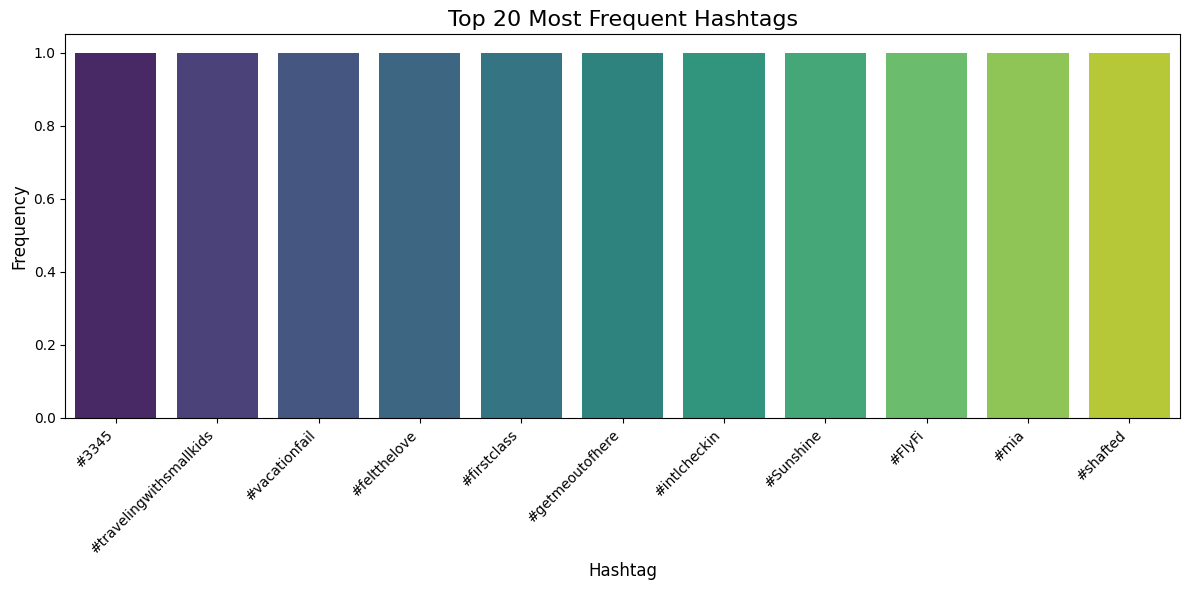

Bar chart of top hashtags displayed.


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create a bar chart
sns.barplot(x='Hashtag', y='Frequency', data=df_top_hashtags, palette='viridis')

# Add title and labels
plt.title(f'Top {top_n} Most Frequent Hashtags', fontsize=16)
plt.xlabel('Hashtag', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Rotate x-axis labels for better readability if there are many hashtags
plt.xticks(rotation=45, ha='right')

# Ensure layout is tight to prevent labels from overlapping
plt.tight_layout()

# Display the plot
plt.show()

print("Bar chart of top hashtags displayed.")

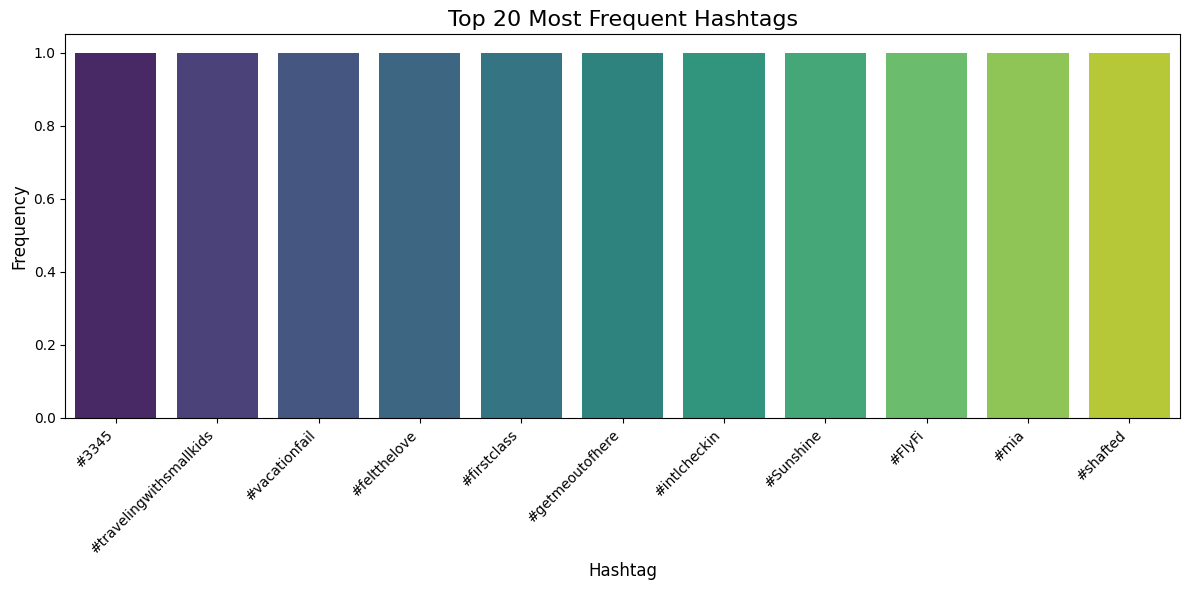

Bar chart of top hashtags displayed.


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create a bar chart, explicitly setting hue and legend=False to avoid FutureWarning
sns.barplot(x='Hashtag', y='Frequency', data=df_top_hashtags, palette='viridis', hue='Hashtag', legend=False)

# Add title and labels
plt.title(f'Top {top_n} Most Frequent Hashtags', fontsize=16)
plt.xlabel('Hashtag', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Rotate x-axis labels for better readability if there are many hashtags
plt.xticks(rotation=45, ha='right')

# Ensure layout is tight to prevent labels from overlapping
plt.tight_layout()

# Display the plot
plt.show()

print("Bar chart of top hashtags displayed.")

In [21]:
df_negative_tweets = df_tweets[df_tweets['airline_sentiment'] == 'negative']

print(f"DataFrame 'df_negative_tweets' created with {len(df_negative_tweets)} negative tweets.")
print(df_negative_tweets[['airline_sentiment', 'cleaned_text']].head())

DataFrame 'df_negative_tweets' created with 9178 negative tweets.
   airline_sentiment                                       cleaned_text
3           negative   it's really aggressive to blast obnoxious "en...
4           negative           and it's a really big bad thing about it
5           negative   seriously would pay $30 a flight for seats th...
15          negative                     SFO-PDX schedule is still MIA.
17          negative    I flew from NYC to SFO last week and couldn'...


In [22]:
all_negative_pos_tags = [pos_tag for sublist in df_negative_tweets['pos_tags'] if sublist for pos_tag in sublist]

print(f"Total number of POS tags extracted from negative tweets: {len(all_negative_pos_tags)}")
print(f"First 10 POS tags: {all_negative_pos_tags[:10]}")

Total number of POS tags extracted from negative tweets: 175137
First 10 POS tags: ['PRON', 'AUX', 'ADV', 'ADJ', 'PART', 'VERB', 'ADJ', 'NOUN', 'ADP', 'PRON']


In [23]:
from collections import Counter

pos_tag_counts = Counter(all_negative_pos_tags)

print("POS tag counts generated.")
print(f"Top 5 most common POS tags: {pos_tag_counts.most_common(5)}")

POS tag counts generated.
Top 5 most common POS tags: [('NOUN', 35192), ('VERB', 25932), ('PRON', 21192), ('ADP', 18032), ('AUX', 13798)]


In [24]:
import pandas as pd

df_pos_counts = pd.DataFrame(pos_tag_counts.items(), columns=['POS Tag', 'Frequency'])

# Sort by frequency in descending order for better visualization
df_pos_counts = df_pos_counts.sort_values(by='Frequency', ascending=False)

print("DataFrame of POS tag counts created.")
print(df_pos_counts.head())

DataFrame of POS tag counts created.
  POS Tag  Frequency
6    NOUN      35192
5    VERB      25932
0    PRON      21192
7     ADP      18032
1     AUX      13798


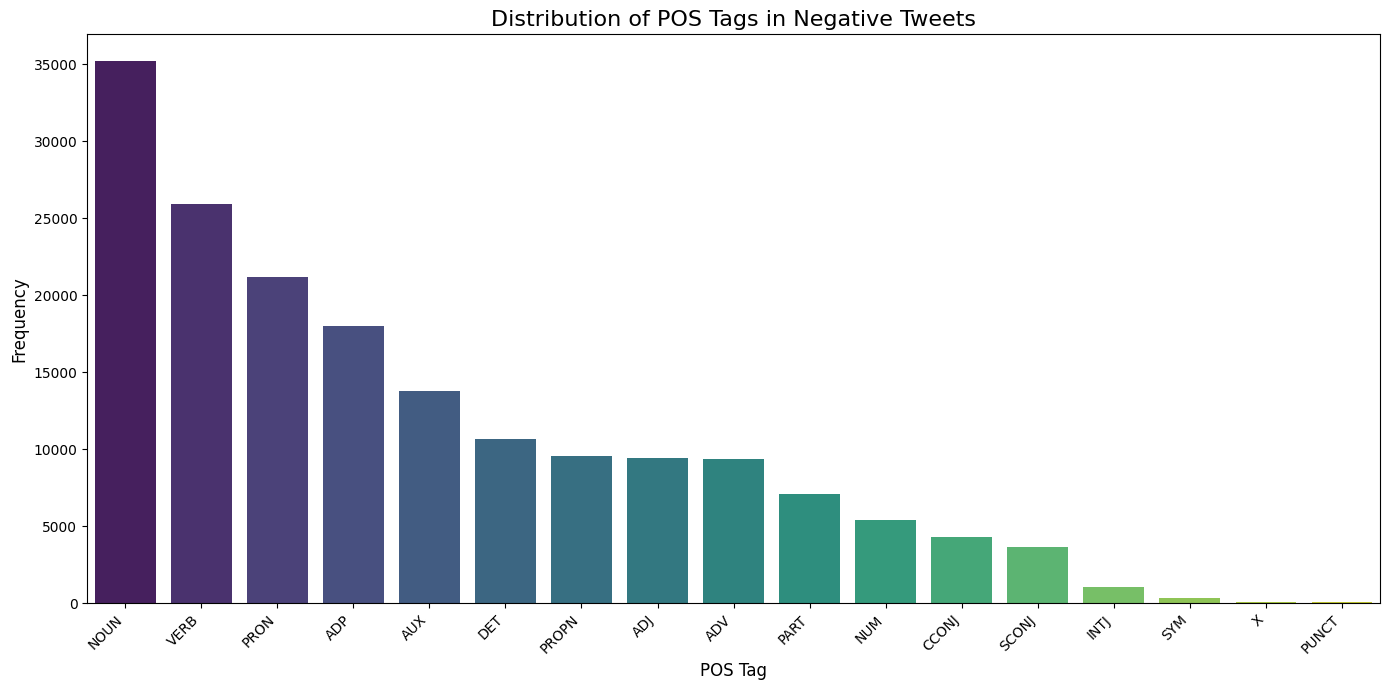

Bar chart of POS tag distribution in negative tweets displayed.


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size for better readability
plt.figure(figsize=(14, 7))

# Create a bar chart, explicitly setting hue and legend=False to avoid FutureWarning
sns.barplot(x='POS Tag', y='Frequency', data=df_pos_counts, palette='viridis', hue='POS Tag', legend=False)

# Add title and labels
plt.title('Distribution of POS Tags in Negative Tweets', fontsize=16)
plt.xlabel('POS Tag', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Ensure layout is tight to prevent labels from overlapping
plt.tight_layout()

# Display the plot
plt.show()

print("Bar chart of POS tag distribution in negative tweets displayed.")